In [1]:
import pandas as pd
import random


In [2]:
station_info = pd.read_csv('../output/zcm/station_infos100000.csv')

In [5]:
def mape_hour(station_info):
    station_info = station_info[station_info['num_current_car']>0]
    # 仿真步长
    step_length = 5*60

    import ast
    station_info_table = station_info[['station_id','lon','lat','max_capacity','charge_speed_station']].drop_duplicates().copy()
    station_info = station_info[['station_id','time','current_car','waiting_car']]

    station_info['time'] = pd.to_datetime(station_info['time'])
    station_info['current_car'] = station_info['current_car'].apply(lambda a:ast.literal_eval(a))
    station_info['waiting_car'] = station_info['waiting_car'].apply(lambda a:ast.literal_eval(a))
    station_info.sort_values(by=['station_id','time'],inplace=True)


    # 将current_car和waiting_car列转换为车辆记录的列表
    current_car_infos = station_info[['station_id','time','current_car']].explode('current_car')
    current_car_infos = current_car_infos[~current_car_infos['current_car'].isnull()]
    current_car_infos = current_car_infos.sort_values(by=['current_car','time'])[['current_car','time','station_id']]
    waiting_car_infos = station_info[['station_id','time','waiting_car']].explode('waiting_car')
    waiting_car_infos = waiting_car_infos[~waiting_car_infos['waiting_car'].isnull()]
    waiting_car_infos = waiting_car_infos.sort_values(by=['waiting_car','time'])[['waiting_car','time','station_id']]
    def get_charging_order(current_car_infos):
        current_car_infos['timegap'] = current_car_infos['time'].diff().dt.total_seconds().fillna(1000000).astype(int)
        current_car_infos['order_id'] = (current_car_infos['timegap']>step_length).cumsum()
        charge_info_s = current_car_infos.groupby(['current_car','order_id']).first().reset_index()
        charge_info_e = current_car_infos.groupby(['current_car','order_id']).last().reset_index()
        charging_order = pd.merge(charge_info_s,charge_info_e,on=['current_car','order_id','station_id'])
        charging_order
        charging_order = charging_order[['current_car','order_id','time_x','time_y','station_id']]
        charging_order.columns = ['carid','order_id','stime','etime','station_id']
        charging_order['duration'] = (charging_order['etime']-charging_order['stime']).dt.total_seconds()
        charging_order = charging_order[charging_order['duration']>0]
        return charging_order
    
    # 计算充电信息
    charging_orders = get_charging_order(current_car_infos)
    # 计算等待信息
    waiting_orders =  get_charging_order(waiting_car_infos.rename(columns={'waiting_car':'current_car'}))
    # 保存充电信息和等待信息
    charging_orders = pd.merge(charging_orders,station_info_table)
    waiting_orders = pd.merge(waiting_orders,station_info_table)
    # 计算充电时长
    charging_orders['duration'] = (charging_orders['etime']-charging_orders['stime']).dt.total_seconds()
    waiting_orders['duration'] = (waiting_orders['etime']-waiting_orders['stime']).dt.total_seconds()
    # grid=pd.read_csv('./mape/grid.csv')
    charging_orders['day'] = charging_orders['stime'].dt.day
    charging_orders['hour'] = charging_orders['stime'].dt.hour
    charging_orders_hour_agg = charging_orders.groupby(['station_id','hour','lon','lat'])['carid'].count().reset_index()
    charging_orders_hour_agg.rename(columns={'carid':'count'},inplace=True)
    charging_orders_hour_agg.sort_values(by=['station_id','hour'],inplace=True)
    return charging_orders_hour_agg
charge_order = mape_hour(station_info)    

In [6]:
import random
charge_order['count'] = charge_order['count'].apply(lambda x: x*random.randint(8, 12))
charge_order

,station_id,hour,lon,lat,count
0,10068_private,10,121.263982,31.312980,11
1,10126_private,4,121.707653,31.225531,11
2,1013_dc,0,121.392489,31.113173,27
3,1013_dc,1,121.392489,31.113173,24
4,1013_dc,5,121.392489,31.113173,10
...,...,...,...,...,...
4943,997_dc,21,121.484631,31.110150,40
4944,997_dc,22,121.484631,31.110150,36
4945,99830_private,22,121.217921,31.265029,11
4946,99847_private,15,121.370781,31.282667,9


In [7]:
charge_order_day = charge_order.groupby(['station_id','lon','lat'])['count'].sum().reset_index()
charge_order_day

,station_id,lon,lat,count
0,10068_private,121.263982,31.312980,11
1,10126_private,121.707653,31.225531,11
2,1013_dc,121.392489,31.113173,299
3,10251_dc,121.341058,31.157789,1130
4,1026_dc,121.438060,31.114918,46
...,...,...,...,...
1298,99586_private,121.477073,31.116605,8
1299,997_dc,121.484631,31.110150,632
1300,99830_private,121.217921,31.265029,11
1301,99847_private,121.370781,31.282667,9


In [8]:
charge_order['station_id'] = charge_order['station_id'].apply(lambda x: int(x.split('_')[0]))
charge_order.rename(columns={'station_id':'stationId'},inplace=True)

In [9]:
charge_order_agg = charge_order.groupby(['stationId','lon','lat'])['count'].sum().reset_index()
charge_order_agg

,stationId,lon,lat,count
0,23,121.341441,30.735442,305
1,25,121.330571,30.738310,675
2,43,121.209149,31.136453,12
3,48,121.446530,31.391770,16
4,74,121.209395,31.202268,12
...,...,...,...,...
1298,99504,121.529769,31.169148,11
1299,99586,121.477073,31.116605,8
1300,99830,121.217921,31.265029,11
1301,99847,121.370781,31.282667,9


In [173]:
import geopandas as gpd 
order = pd.read_csv('../tmp1/1_orderInfo.csv')
shunyi_station = gpd.read_file('../tmp1/修正_all_stations_wgs84.json')
shunyi_station = shunyi_station[['stationId','stationLon','stationLat']]
order = pd.merge(order,shunyi_station,on=['stationId'],how='left')
# map = pd.read_csv('../tmp1/shunyip_to_hw.csv')

In [174]:
import geopandas as gpd
from shapely.geometry import Point
order['geometry'] = order.apply(lambda row: Point(row['stationLon'], row['stationLat']), axis=1)
days = len(order['day'].unique())
test = order.groupby(['stationId'])['order'].sum().reset_index()
test['order'] = test['order'].apply(lambda x: int(x/days))
test

,stationId,order
0,45856,667
1,45906,0
2,45909,0
3,45910,0
4,45922,385
...,...,...
1194,67478,2
1195,67512,3
1196,67573,258
1197,67610,2


In [175]:
test = pd.merge(test,order[['stationId','geometry']],on=['stationId'],how='left')
test.drop_duplicates(subset=['stationId','order'],inplace=True)

In [176]:
test = gpd.GeoDataFrame(test,geometry='geometry')
test.to_file('./shunyi.json',driver='GeoJSON')

In [177]:
charge_order_agg['geometry'] = charge_order_agg.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
charge_order_agg

,stationId,lon,lat,count,geometry
0,16,121.342773,30.731904,104,POINT (121.342773 30.731904)
1,19,121.346951,30.733446,8,POINT (121.346951 30.733446)
2,21,121.353645,30.733667,63,POINT (121.353645 30.733667)
3,22,121.368576,30.733864,71,POINT (121.368576 30.733864)
4,23,121.341441,30.735442,51,POINT (121.341441 30.735442)
...,...,...,...,...,...
2601,99531,121.714864,31.130611,8,POINT (121.714864 31.130611)
2602,99603,121.333199,31.405464,12,POINT (121.333199 31.405464)
2603,99652,121.377927,31.065900,8,POINT (121.377927 31.0659)
2604,99714,121.273363,31.228037,8,POINT (121.273363 31.228037)


In [178]:
import transbigdata as tbd 
corresponding_station = tbd.ckdnearest_point(order,charge_order_agg)
corresponding_station

,stationId_x,month,day,hour,order,stationLon,stationLat,geometry_x,dist,index,stationId_y,lon,lat,count,geometry_y
0,45856,1,11,16,44,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632,2786,121.528692,31.292744,92,POINT (121.528692 31.292744)
1,45856,1,11,17,29,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632,2786,121.528692,31.292744,92,POINT (121.528692 31.292744)
2,45856,1,11,18,27,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632,2786,121.528692,31.292744,92,POINT (121.528692 31.292744)
3,45856,1,11,19,29,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632,2786,121.528692,31.292744,92,POINT (121.528692 31.292744)
4,45856,1,11,20,17,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632,2786,121.528692,31.292744,92,POINT (121.528692 31.292744)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280268,67456,2,18,14,7,121.447101,31.256915,POINT (121.4471007067111 31.25691454016555),0.000182,1372,14266,121.446931,31.256848,144,POINT (121.4469312894772 31.25684821537272)
280269,67456,2,18,15,8,121.447101,31.256915,POINT (121.4471007067111 31.25691454016555),0.000182,1372,14266,121.446931,31.256848,144,POINT (121.4469312894772 31.25684821537272)
280270,67456,2,18,16,2,121.447101,31.256915,POINT (121.4471007067111 31.25691454016555),0.000182,1372,14266,121.446931,31.256848,144,POINT (121.4469312894772 31.25684821537272)
280271,67456,2,18,17,3,121.447101,31.256915,POINT (121.4471007067111 31.25691454016555),0.000182,1372,14266,121.446931,31.256848,144,POINT (121.4469312894772 31.25684821537272)


C:\Users\30684\AppData\Local\Temp\ipykernel_30196\1234578555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corresponding_station.drop_duplicates(subset=['stationId_x','stationId_y'],inplace=True)


(array([116., 110., 140., 134., 131., 100.,  86.,  81.,  70.,  44.,  38.,
         11.,  19.,  19.,  15.,   7.,   2.,   6.,   7.,   4.,   6.,   3.,
          4.,   7.,   2.,   1.,   3.,   0.,   1.,   1.,   4.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   1.,   0.,   1.,   3.,   2.,   0.,
          0.,   0.,   1.,   0.,   0.,   2.,   1.,   2.,   1.,   0.,   1.,
          0.,   0.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          3.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.]),
 array([ 0.        ,  0.86910393,  1.73820785,  2.60731178,  3.47641571,
         4.34551963,  5.21462356,  6.08372748,  6.95283141,  7.82193534,
         8.69103926,  9.56014319, 10.42924712, 11.29835104, 12.16745497,
        13.03655889, 13.90566282, 14.77476675, 15.64387067, 16.5129746 ,
        17.38207853, 18.25

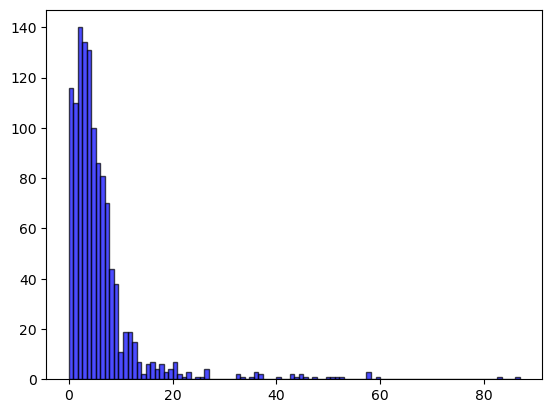

In [201]:
import matplotlib.pyplot as plt
corresponding_station.drop_duplicates(subset=['stationId_x','stationId_y'],inplace=True)
plt.hist(corresponding_station['dist']*1000, bins=100, alpha=0.7, color='blue', edgecolor='black')

In [179]:
corresponding_station = corresponding_station[['stationId_x','stationId_y','dist']]
corresponding_station['dist_min'] = corresponding_station.groupby(['stationId_x','stationId_y'])['dist'].transform('min')
corresponding_station_min = corresponding_station[corresponding_station['dist']==corresponding_station['dist_min']]
corresponding_station_min

C:\Users\30684\AppData\Local\Temp\ipykernel_30196\2104491986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corresponding_station['dist_min'] = corresponding_station.groupby(['stationId_x','stationId_y'])['dist'].transform('min')


,stationId_x,stationId_y,dist,dist_min
0,45856,2786,0.004848,0.004848
1,45856,2786,0.004848,0.004848
2,45856,2786,0.004848,0.004848
3,45856,2786,0.004848,0.004848
4,45856,2786,0.004848,0.004848
...,...,...,...,...
280268,67456,14266,0.000182,0.000182
280269,67456,14266,0.000182,0.000182
280270,67456,14266,0.000182,0.000182
280271,67456,14266,0.000182,0.000182


In [180]:
corresponding_station_min.drop_duplicates(subset=['stationId_x','stationId_y'],inplace=True)
corresponding_station_min

,stationId_x,stationId_y,dist,dist_min
0,45856,2786,0.004848,0.004848
914,46477,2786,0.004212,0.004212
915,45906,70642,0.004907,0.004907
916,55063,70642,0.005167,0.005167
1078,45909,2035,0.000122,0.000122
...,...,...,...,...
278472,67286,50122,0.003652,0.003652
278473,67358,46785,0.003044,0.003044
279380,67400,11464,0.005405,0.005405
279381,67456,14266,0.000182,0.000182


In [181]:
charge_order_agg.rename(columns={'stationId':'stationId_y'},inplace=True)
charge_order_agg = pd.merge(charge_order_agg,corresponding_station_min[['stationId_x','stationId_y']],on=['stationId_y'])
charge_order_agg

,stationId_y,lon,lat,count,geometry,index,stationId_x
0,25,121.330571,30.738310,56,POINT (121.330571 30.73831),6,57150
1,25,121.330571,30.738310,56,POINT (121.330571 30.73831),6,57356
2,39,121.318964,30.749937,48,POINT (121.318964 30.749937),10,57362
3,66,121.198826,30.803262,43,POINT (121.198826 30.803262),14,47240
4,66,121.198826,30.803262,43,POINT (121.198826 30.803262),14,57342
...,...,...,...,...,...,...,...
1212,99400,121.305520,30.727909,9,POINT (121.30552 30.727909),2599,46175
1213,99400,121.305520,30.727909,9,POINT (121.30552 30.727909),2599,46614
1214,99400,121.305520,30.727909,9,POINT (121.30552 30.727909),2599,55091
1215,99400,121.305520,30.727909,9,POINT (121.30552 30.727909),2599,57158


In [182]:
order

,stationId,month,day,hour,order,stationLon,stationLat,geometry,dist,index
0,45856,1,11,16,44,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632
1,45856,1,11,17,29,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632
2,45856,1,11,18,27,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632
3,45856,1,11,19,29,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632
4,45856,1,11,20,17,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632
...,...,...,...,...,...,...,...,...,...,...
280268,67573,2,18,15,26,121.428879,31.181507,POINT (121.4288791545701 31.18150737113631),0.003216,2457
280269,67573,2,18,16,16,121.428879,31.181507,POINT (121.4288791545701 31.18150737113631),0.003216,2457
280270,67573,2,18,17,10,121.428879,31.181507,POINT (121.4288791545701 31.18150737113631),0.003216,2457
280271,67610,1,11,16,70,121.358859,31.106300,POINT (121.3588585161662 31.10629973727251),0.003200,177


In [183]:
order

,stationId,month,day,hour,order,stationLon,stationLat,geometry,dist,index
0,45856,1,11,16,44,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632
1,45856,1,11,17,29,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632
2,45856,1,11,18,27,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632
3,45856,1,11,19,29,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632
4,45856,1,11,20,17,121.524389,31.290510,POINT (121.5243893743935 31.29050978359567),0.004848,632
...,...,...,...,...,...,...,...,...,...,...
280268,67573,2,18,15,26,121.428879,31.181507,POINT (121.4288791545701 31.18150737113631),0.003216,2457
280269,67573,2,18,16,16,121.428879,31.181507,POINT (121.4288791545701 31.18150737113631),0.003216,2457
280270,67573,2,18,17,10,121.428879,31.181507,POINT (121.4288791545701 31.18150737113631),0.003216,2457
280271,67610,1,11,16,70,121.358859,31.106300,POINT (121.3588585161662 31.10629973727251),0.003200,177


In [184]:
days = len(order['day'].unique())
order = order.groupby(['stationId'])['order'].sum().reset_index()
order['order'] = order['order'].apply(lambda x: int(x/days))
order

,stationId,order
0,45856,667
1,45906,0
2,45909,0
3,45910,0
4,45922,385
...,...,...
1194,67478,2
1195,67512,3
1196,67573,258
1197,67610,2


In [185]:
charge_order_agg['count'].max(), charge_order_agg['count'].min()

(302, 8)

In [186]:
order['order'].max(), order['order'].min()

(843, 0)

(array([694., 104.,  74.,  50.,  41.,  34.,  30.,  25.,  13.,  13.,  21.,
         13.,  12.,   5.,   9.,   7.,   9.,   0.,   4.,   3.,   4.,   3.,
          7.,   1.,   0.,   0.,   0.,   1.,   3.,   2.,   1.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          0.,   1.,   3.,   0.,   0.,   0.,   1.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

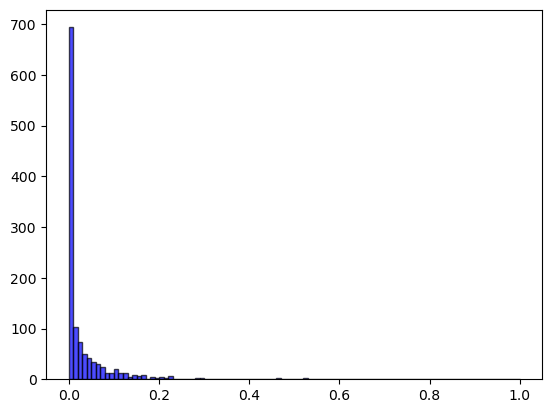

In [187]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 假设df是你的DataFrame
scaler = MinMaxScaler()

order['nor_order'] = scaler.fit_transform(order[['order']])

plt.hist(order['nor_order'], bins=100, alpha=0.7, color='blue', edgecolor='black')


(array([191., 146.,   6.,  43.,  35.,  11.,   8.,  16.,  13.,  10.,  15.,
         16.,   8.,   9.,   4.,  10.,   3.,  15.,  12.,   4.,  10.,   9.,
          4.,  25.,   8.,   5.,  12.,  13.,  12.,  18.,  30.,  12.,  13.,
         18.,  17.,  19.,  10.,  13.,  18.,  10.,  11.,  18.,  21.,  13.,
          9.,  14.,  13.,  33.,  22.,  16.,  10.,  18.,  13.,  12.,   4.,
         10.,  11.,   9.,  11.,   7.,   6.,   7.,   5.,   4.,   3.,   4.,
          5.,   9.,   6.,   3.,   2.,   3.,   6.,   4.,   8.,   3.,   0.,
          0.,   2.,   1.,   0.,   2.,   0.,   0.,   2.,   2.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

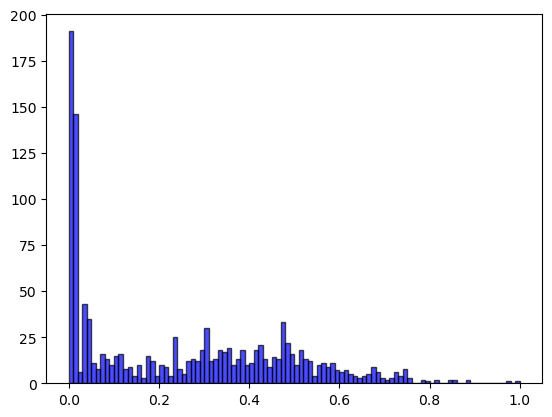

In [188]:

charge_order_agg['nor_count'] = scaler.fit_transform(charge_order_agg[['count']])
plt.hist(charge_order_agg['nor_count'], bins=100, alpha=0.7, color='blue', edgecolor='black')

In [189]:
charge_order_agg

,stationId_y,lon,lat,count,geometry,index,stationId_x,nor_count
0,25,121.330571,30.738310,56,POINT (121.330571 30.73831),6,57150,0.163265
1,25,121.330571,30.738310,56,POINT (121.330571 30.73831),6,57356,0.163265
2,39,121.318964,30.749937,48,POINT (121.318964 30.749937),10,57362,0.136054
3,66,121.198826,30.803262,43,POINT (121.198826 30.803262),14,47240,0.119048
4,66,121.198826,30.803262,43,POINT (121.198826 30.803262),14,57342,0.119048
...,...,...,...,...,...,...,...,...
1212,99400,121.305520,30.727909,9,POINT (121.30552 30.727909),2599,46175,0.003401
1213,99400,121.305520,30.727909,9,POINT (121.30552 30.727909),2599,46614,0.003401
1214,99400,121.305520,30.727909,9,POINT (121.30552 30.727909),2599,55091,0.003401
1215,99400,121.305520,30.727909,9,POINT (121.30552 30.727909),2599,57158,0.003401


In [190]:
order.rename(columns={'stationId':'stationId_x'},inplace=True)
order

,stationId_x,order,nor_order
0,45856,667,0.791222
1,45906,0,0.000000
2,45909,0,0.000000
3,45910,0,0.000000
4,45922,385,0.456702
...,...,...,...
1194,67478,2,0.002372
1195,67512,3,0.003559
1196,67573,258,0.306050
1197,67610,2,0.002372


In [195]:
total = pd.merge(charge_order_agg,order,on=['stationId_x'],how='inner')
def calculate_mape(row):
        actual = row["nor_order"]
        forecast = row["nor_count"]
        if actual == 0:
            return (row['nor_count']*100)
        else:
            return abs((actual - forecast) / actual) * 100
total['mape'] = total.apply(calculate_mape,axis=1)

In [198]:
len(total[total['mape']<300]),len(total)
test = total[total['mape']<300]
test['mape'].mean(),len(total[total['mape']<300]),len(total)

(50.28768422834846, 848, 1217)

(array([909.,  80.,  49.,  40.,  15.,  15.,  13.,  12.,  10.,   5.,   4.,
          4.,   3.,   2.,   8.,   5.,   0.,   1.,   0.,   1.,   1.,   3.,
          1.,   2.,   1.,   0.,   1.,   0.,   1.,   1.,   0.,   2.,   1.,
          0.,   2.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   2.,   1.,   0.,   1.,   1.,   0.,   2.,   1.,   0.,
          0.,   0.,   3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([    0.        ,   635.55102041,  1271.10204082,  1906.65306122,
         2542.20408163,  3177.75510204,  3813.30612245,  4448.85714286,
         5084.40816327,  5719.95918367,  6355.51020408,  6991.06122449,
         7626.6122449 ,  8262.16326531,  8897.71428571,  9533.26530612,
        10168.81632653, 10804.

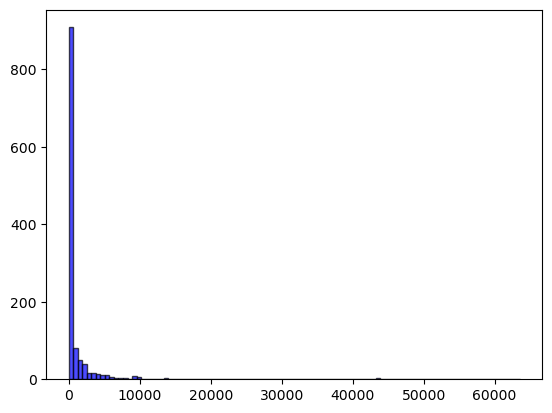

In [193]:
plt.hist(total['mape'], bins=100, alpha=0.7, color='blue', edgecolor='black')

In [194]:
order = order[(order['month']==1)&(order['day']==20)]
order_aqg = order.groupby('stationId')['order'].sum().reset_index()
order_aqg

KeyError: 'month'

In [ ]:
charge_order_agg.rename(columns={'stationId':'myid'},inplace=True)
charge_order_map = pd.merge(charge_order_agg,map,on=['myid'],how='left')
charge_order_map

In [ ]:
charge_order_map.dropna(subset=['stationId'],inplace=True)
charge_order_map

In [ ]:
charge_order_map = charge_order_map[['count','stationId']]
charge_order_map['stationId'] = charge_order_map['stationId'].astype(int)
agg = pd.merge(charge_order_map,order_aqg,on=['stationId'],how='left')

In [ ]:
agg['order'] = agg['order'].fillna(0)
agg

In [ ]:
test = agg[agg['order']>0]
test

In [ ]:
def normalize(df, column_name):
        df[column_name] = (df[column_name] - df[column_name].min()) / (df[column_name].max() - df[column_name].min())
        return df

In [ ]:
agg = normalize(agg,'count')
agg = normalize(agg,'order')


In [ ]:
def calculate_mape(row):
        actual = row["order"]
        forecast = row["count"]
        if actual == 0:
            return 0
        else:
            return abs((actual - forecast) / actual) * 100
agg['mape'] = agg.apply(calculate_mape,axis=1)

In [ ]:
agg['mape'].mean()

In [ ]:
len(agg[agg['mape']>300])/len(agg)